# Customised extension with `halomod`

In this tutorial, we use the existing infrastructure of `halomod` and plug in a new type of tracer, namely HI using the model from 1611.06235. This model requires three additions: a new density profile for HI; a new concentration-mass relation for HI; and finally a new HI HOD. Notice that you can also add a lot of other stuff into `halomod` as well, however, most likely you'll need to add something to build a new type of tracer, which is the case here.

Let's import a few baisc things first:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from halomod import TracerHaloModel
import halomod
import hmf
import scipy

In [2]:
print("halomod version: ", halomod.__version__)
print("hmf version:", hmf.__version__)

halomod version:  1.4.6.dev71+gaca1ec0
hmf version: 3.1.0


## Creating a new density profile

The HI density profile used here is:

$$
\rho_{\rm HI}(r) = \rho_0 \;{\rm exp}(-r/r_s)
$$


Notice that all the infrastructure has been set up by `Profile` class, and all you need to modify is the `_f` function, its integration `_h` and its Fourier transform `_p` (see documentation for `profiles.py`)

In [3]:
from halomod.profiles import Profile

In [4]:
class Exponential(Profile):
    def _f(self, x):
        return np.exp(-x)

    def _h(self, c):
        return 2-2*np.exp(-c)-2*c*np.exp(-c)-c**2*np.exp(-c)

    def _p(self, K, c=None):
        sin = np.sin(c*K)
        cos = np.cos(c*K)
        func1 = (1+K**2)**(-2)
        exp = np.exp(c)
        return func1/K/exp*(2*exp*K-K*(2+c+c*K**2)*cos-(1+c-K**2+c*K**2)*sin)

At bare minimum, you should specify `_f` which is just the density profile itself, and all the integration and Fourier transformation will be done numerically. However, that is very inefficient so you should always find analytical expression and specify if you can.

Now let's plug it into a halo model:

In [5]:
hm = TracerHaloModel(tracer_profile_model=Exponential)

And see the profile for a halo of mass $10^{10} M_\odot h^{-1}$ in Fourier space:

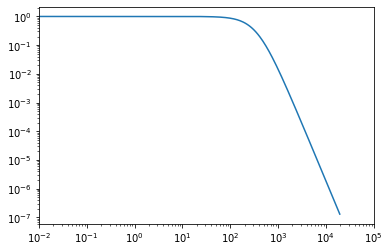

In [29]:
plt.plot(hm.k,hm.tracer_profile_ukm[:,1000]);
plt.xscale('log')
plt.yscale('log')
plt.xlim((1e-2,1e5));
#plt.ylim((1e-1,1))

And we've set up our profile model.

This profile model does not have additional model parameters. If it does, you can always update these parameters using 
```python
hm = TracerHaloModel(tracer_profile_model=YourProfile,tracer_profile_params=YourParameters)
```

## Creating a new concentration-mass relation

The concentration-mass relation we use here follows the one from Maccio et al.(2007):

$$
c_{\rm HI}(M,z) = c_0 \Big(\frac{M}{10^{11}{\rm M_\odot h^{-1}}}\Big)^{-0.109}\frac{4}{(1+z)^\gamma}
$$

Again, because `halomod` already has a generic `CMRelation` class in place, all you really need is to specify a `cm` function for the equation above:

In [30]:
from halomod.concentration import CMRelation

In [31]:
class Maccio07(CMRelation):
    """
        HI concentration-mass relation based on Maccio et al.(2007). Default value taken from 1611.06235
        """
    _defaults = {'c_0': 28.65, "gamma": 1.45}

    def cm(self,m,z):
        return self.params['c_0']*(m*10**(-11))**(-0.109)*4/(1+z)**self.params['gamma']

And update our halo model with it:

In [33]:
hm.update(tracer_concentration_model=Maccio07)

And check the concentration-mass relation at z=0:

(0.0, 600.0)

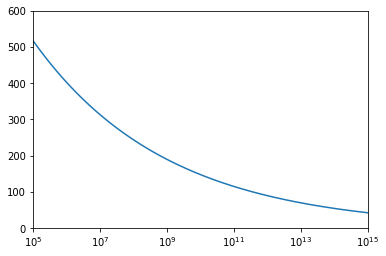

In [44]:
plt.plot(hm.m,hm.tracer_concentration.cm(hm.m,0))
plt.xscale('log')
plt.xlim(1e5,1e15)
plt.ylim((0,600))

Notice that this model has two additional parameters, which can be updated using:

In [45]:
hm.update(tracer_concentration_params=dict({'c_0': 28.65, "gamma": 1.45}))

## Creating a new HOD

The HI HOD we use here is:

$$
M_{\rm HI}(M) = \alpha f_{H,c} M \Big(\frac{M}{10^{11}M_\odot {\rm h}^{-1}}\big)^\beta
{\rm exp}\Bigg[-\Big(\frac{v_{c0}}{v_c(M)}\Big)^3\Bigg]
$$

For HOD, it's a bit more complicated. First, one need to decide what type of tracer it is. The most generic class to use is `HOD`, however, you may prefer `HODBulk` where the tracer is considered to be continueous distributed ; or `HODPoisson`, which assumes Poisson distributed discrete satellite components, which is commonly used for galaxies.

Second, if your model has a minimum halo mass to host any tracer as a sharp cut-off (or not), you need specify 

```python
sharp_cut = True # or False
```

If your model has a seperation of central and satellite components, you need to specify if the satellite occupation is inherently dependant on the central occupation:

```python
central_condition_inherent = False # or True
```

If True, the actual satellite component will be your satellite occupation times central occupation.

Finally, you need to specify how to convert the unit between your HOD and the resulting power spectrum. For example, for HI the HOD is written in mass unit, whereas the power spectrum is in temperature unit. This is done by specifying a `unit_conversion` function

Additionally, sometimes your HOD contains function that need to be calculated, such as virial velocity in this case, which you can just put into the class:

In [49]:
from halomod.hod import HODBulk
import scipy.constants as const
import astropy.constants as astroconst

For simple demonstration, we simplify the HOD a bit:

In [70]:
class Padmanabhan(HODBulk):
    """
    A continuous HOD following Padmanabhan & Refregier (1607.01021)
    """
    _defaults = {"alpha": 0.09,  # gives HI mass amplitude
                 "f_Hc": 0.12,  # gives HI mass amplitude, fixed by Yp and Omegab
                 "beta": -0.58, #slop of mass
                 "M_min": 9, # Truncation Mass, if needed
                 "M_1": 11,  # Characteristic Mass
                 "M_max": 18,   # Truncation mass, if needed
                 }
    sharp_cut = False
        
    def _satellite_occupation(self, m):
        '''Notice that for Bulk distribution, there's only satellite distribution. '''
        alpha = self.params['alpha']
        f_Hc = self.params['f_Hc']
        beta = self.params['beta']
        M_1 = 10 ** self.params['M_1']

        out = alpha*f_Hc*m*(m/M_1)**beta
        return out

    def unit_conversion(self, cosmo, z):
        """A factor (potentially with astropy units) to convert 
        the total occupation to a desired unit.
        In this case from solar mass to temperature unit"""
        A12=2.869e-15
        nu21cm=1.42e9
        Const=( 3.0*A12*const.h*const.c**3.0 )/( 32.0*np.pi*(const.m_p+const.m_e)*const.Boltzmann * nu21cm**2);
        Mpcoverh_3=((astroconst.kpc.value*1e3)/(cosmo.H0.value/100.0) )**3
        hubble = cosmo.H0.value * cosmo.efunc(z)*1.0e3/(astroconst.kpc.value*1e3)
        temp_conv=Const * ((1.0+z)**2/hubble)
        # convert to Mpc^3, solar mass
        temp_conv=temp_conv/Mpcoverh_3 * astroconst.M_sun.value
        return temp_conv


And now update the halo model with this newly defined HOD:

In [71]:
hm.update(hod_model=Padmanabhan)

You can check out the mean density of this HI in solar mass over Mpc^3 unit:

In [72]:
hm.mean_tracer_den

756951559.9143287

And in temeperature unit:

In [73]:
hm.mean_tracer_den_unit

0.00023797929128430576

You can easily update the parameters using:

In [75]:
hm.update(hod_params=dict({"beta": -0.68}))

And to confirm it is indeed updated let's check the density again:

In [76]:
print(hm.mean_tracer_den)
print(hm.mean_tracer_den_unit)

1003872103.8453474
0.00031560906201215757


And the power spectrum in length unit:

/home/ztchen/work/gitproject/halomod/src/halomod/tools.py:534: RuntimeWarning: invalid value encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)
/home/ztchen/work/gitproject/halomod/src/halomod/tools.py:534: RuntimeWarning: divide by zero encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)


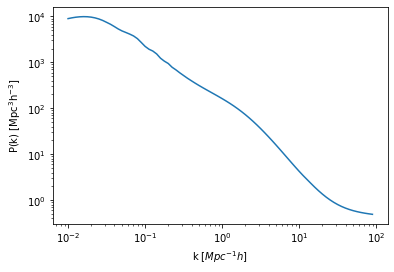

In [77]:
plt.plot(hm.k_hm, hm.power_auto_tracer)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm Mpc^3}h^{-3}]$");

And in temperature unit:

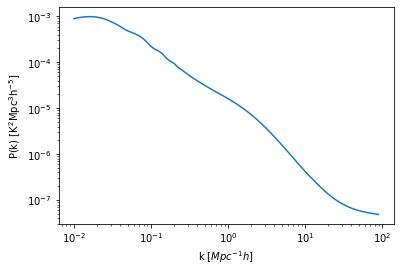

In [78]:
plt.plot(hm.k_hm, hm.power_auto_tracer*hm.mean_tracer_den_unit**2)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm K^2 Mpc^3}h^{-5}]$");